<a href="https://colab.research.google.com/github/OozyGrub/nasdaq100-trading-algorithm/blob/main/nasdaq100_trading_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
!pip install yfinance -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install --upgrade -q ta


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Preparation

In [ ]:
# configuration
period = '2y'

In [ ]:
# msft = yf.Ticker("MSFT")
# aapl = yf.Ticker("AAPL")
# get historical market data
# hist = msft.history(period = period)
# hist.plot()
# for hist in tickers:
#     hist.plot()

# stocks = ["MSFT", "AAPL", "AAME", "AACG", "ACIW", "ACRX"]

stocks = ["AAPL","ADBE","ADI","ADP","ADSK",
"AEP","ALGN",
"ALXN",
"AMAT",
"AMD",
"AMGN",
"AMZN",
"ANSS",
"ASML",
"ATVI",
"AVGO",
"BIDU",
"BIIB",
"BKNG",
"CDNS",
"CDW",
"CERN",
"CHKP",
"CHTR",
"CMCSA",
"COST",
"CPRT",
"CSCO",
"CSX",
"CTAS",
"CTSH",
"DLTR",
"DOCU",
"DXCM",
"EA",
"EBAY",
"EXC",
"FAST",
"FB",
"FISV",
"FOX",
"FOXA",
"GILD",
"GOOG",
"GOOGL",
"IDXX",
"ILMN",
"INCY",
"INTC",
"INTU",
"ISRG",
"JD",
"KDP",
"KHC",
"KLAC",
"LRCX",
"LULU",
"MAR",
"MCHP",
"MDLZ",
"MELI",
"MNST",
"MRNA",
"MRVL",
"MSFT",
"MTCH",
"MU",
"MXIM",
"NFLX",
"NTES",
"NVDA",
"NXPI",
"OKTA",
"ORLY",
"PAYX",
"PCAR",
"PDD",
"PEP",
"PTON",
"PYPL",
"QCOM",
"REGN",
"ROST",
"SBUX",
"SGEN",
"SIRI",
"SNPS",
"SPLK",
"SWKS",
"TCOM",
"TEAM",
"TMUS",
"TSLA",
"TXN",
"VRSK",
"VRSN",
"VRTX",
"WBA",
"WDAY",
"XEL",
"XLNX",
"ZM"]
num_stocks = len(stocks)
stock_dict = dict(enumerate(stocks))
idx_to_stock = dict([(val, key) for key, val in stock_dict.items()])

tickers = [yf.Ticker(stock).history(period=period) for stock in stocks]

In [ ]:
# for key, val in msft.info.items():
#     print(f"{key}: {val}")

In [ ]:
# hist['Close'].plot(figsize=(16, 9))

In [ ]:
from ta import add_all_ta_features
from ta.utils import dropna

def with_features(x):
    return add_all_ta_features(x, open="Open", high="High", low="Low", close="Close", volume="Volume")

df = []
for ticker in tickers:
    try:
        x = with_features(ticker)
        df.append(x)
    except:
        print(ticker)

In [ ]:
df[0][['momentum_tsi', 'Close']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 506 entries, 2019-05-06 to 2021-05-06
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   momentum_tsi  469 non-null    float64
 1   Close         506 non-null    float64
dtypes: float64(2)
memory usage: 11.9 KB


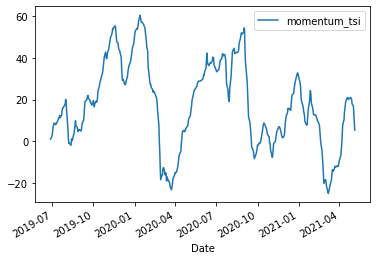

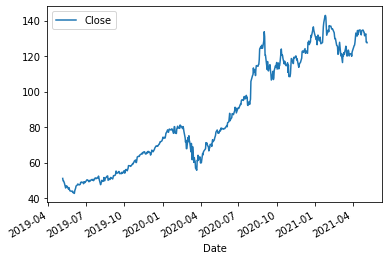

In [ ]:
df[0][['momentum_tsi']].plot()
df[0][['Close']].plot()

## Multiple Strategy

In [ ]:
from datetime import timedelta, date
from dateutil import relativedelta

# configs
decimal_display = 2
start_date = date(2019, 10, 1)
end_date = date(2021, 4, 1)
debug = False
initial_balance = 100.00



def calculate_position_balance(at_date):
    prices = [df[j]['Close'].get(to_date_key(at_date)) if 
              df[j]['Close'].get(to_date_key(at_date)) else 
              find_nearest_price(j, at_date) 
              for j in range(num_stocks)]
    return np.dot(position, prices)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def to_date_key(x):
    return x.strftime("%Y-%m-%d")

def buy(amount, price):
    return amount / price

def sell(amount, price):
    return amount * price

def find_nearest_price(i, date):
    while True:
        date -= timedelta(1)
        if df[i]['Close'].get(to_date_key(date)):
            return df[i]['Close'].get(to_date_key(date))

def find_nearest_tsi(i, date):
    while True:
        date -= timedelta(1)
        if df[i]['momentum_tsi'].get(to_date_key(date)):
            return df[i]['momentum_tsi'].get(to_date_key(date))

def get_tsi_data(date):
    return [(key, x['momentum_tsi'].get(to_date_key(date)) if
             x['momentum_tsi'].get(to_date_key(date)) else
             find_nearest_tsi(key, date)) for
            key, x in enumerate(df)]

In [ ]:
from itertools import permutations, product

month_period_params = [1, 2, 3]
num_stock_hold_params = [5, 10, 20]
sell_threshold_params = [[1.25, 1.50, 1.75]]
sell_ratio_params = [[.2, .2, .2], [.2, .3, .4], [.1, .2, .3]]
cut_loss_threshold_params = [.9, .8, .7]

product_params = list(product(month_period_params,
                   num_stock_hold_params,
                   sell_threshold_params,
                   sell_ratio_params,
                   cut_loss_threshold_params))
product_params_size = len((product_params))

In [ ]:
from tqdm.auto import tqdm, trange

In [ ]:
results = [] # (idx, balance)[]

for idx in trange(product_params_size, desc='product_params'):
    # params
    month_period = product_params[idx][0]
    num_stock_hold = product_params[idx][1]
    sell_threshold = product_params[idx][2]
    sell_ratio = product_params[idx][3]
    cut_loss_threshold = product_params[idx][4]

    # initial vars
    total_balance = initial_balance
    position = [0.00] * num_stocks
    state = [0] * num_stocks
    buy_at = [0.00] * num_stocks
    selected_stock = []
    acc_total_balances = []
    month_count = 0

    trading_token = 0

    def hit_sell_threshold(i, price, buy_price):
        return price >= buy_price * sell_threshold[i]

    def hit_cut_loss_threshold(price, buy_price):
        return price <= buy_price * cut_loss_threshold
        
    for single_date in tqdm(list(daterange(start_date, end_date)),leave=False, desc='date'):
        date_key = to_date_key(single_date)

        # Trading period
        if single_date.day == 1:
            if month_count % month_period == 0:
                trading_token = 1
            month_count += 1

        if trading_token == 1:
            trading_token = 0
            # select stock by top tsi
            tsi_data = get_tsi_data(single_date)
            tsi_data.sort(key=lambda x:-x[1])
            top_stock = tsi_data[5: num_stock_hold + 5]
            selected_stock = list(map(lambda x : x[0], top_stock))
            if debug:
                printmd(f"Month {month_count}")
                # print([stock_dict[i] for i in selected_stock])
                print(list(map(lambda x : (stock_dict[x[0]], x[1]), top_stock)))

            # sell all if not top
            for i in range(num_stocks):
                price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                if position[i] > 0.0 and (i not in selected_stock):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    state[i] = 0
                    buy_at[i] = 0
                    position[i] = 0
                    if debug:
                        # print(position)
                        print(f"{date_key} 🧧 sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

            # buy all top
            partial_balance = total_balance / num_stock_hold
            if partial_balance > 0.0:
                for i in selected_stock:
                    price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                    amount = buy(partial_balance, price)
                    total_balance -= partial_balance
                    position[i] += amount
                    buy_at[i] = price
                    state[i] = 0
                    if debug:
                        # print(position)
                        print(f"{date_key} 🟢 buy {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

        # Watch stock price
        for i in selected_stock:
            price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
            if position[i] > 0.0:
                # sell
                if state[i] < len(sell_threshold) and hit_sell_threshold(state[i], price, buy_at[i]):
                    amount = position[i] * sell_ratio[state[i]]
                    total_balance += sell(amount, price)
                    position[i] -= amount
                    state[i] += 1
                    symbol = "🔴" * state[i]
                    if debug:
                        # print(position)
                        print(f"{date_key} {symbol} sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

                # cut loss
                if hit_cut_loss_threshold(price, buy_at[i]):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    buy_at[i] = 0.0
                    position[i] = 0.0
                    state[i] += 1
                    if debug:
                        # print(position)
                        print(f"{date_key} 🔥 cut_loss {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")
        acc_total_balances.append((single_date, total_balance + calculate_position_balance(single_date)))
        # print(calculate_position_balance(single_date))

    # pd.set_option('display.max_rows', 100)
    # acc_total_balance_df = pd.DataFrame(acc_total_balances)
    # acc_total_balance_df = acc_total_balance_df.set_index(0)
    # acc_total_balance_df.plot(figsize=(8, 8))

    total_balance += calculate_position_balance(end_date)

    # Saving results
    results.append((idx, total_balance))

    if debug: print("-------- 📈 Summary --------")
    print(f"{idx} -> total balance: {round(total_balance, decimal_display)}")

0 -> total balance: 173.81


1 -> total balance: 193.28


2 -> total balance: 193.06


3 -> total balance: 174.18


4 -> total balance: 193.69


5 -> total balance: 193.47


6 -> total balance: 174.59


7 -> total balance: 193.52


8 -> total balance: 192.89


9 -> total balance: 163.29


10 -> total balance: 175.92


11 -> total balance: 187.07


12 -> total balance: 163.45


13 -> total balance: 176.09


14 -> total balance: 187.25


15 -> total balance: 163.66


16 -> total balance: 175.76


17 -> total balance: 186.74


18 -> total balance: 162.65


19 -> total balance: 180.98


20 -> total balance: 191.58


21 -> total balance: 162.46


22 -> total balance: 180.77


23 -> total balance: 191.36


24 -> total balance: 162.92


25 -> total balance: 181.12


26 -> total balance: 191.99


27 -> total balance: 171.94


28 -> total balance: 172.74


29 -> total balance: 171.04


30 -> total balance: 171.44


31 -> total balance: 172.25


32 -> total balance: 170.55


33 -> total balance: 174.07


34 -> total balance: 175.11


35 -> total balance: 173.38


36 -> total balance: 179.51


37 -> total balance: 165.53


38 -> total balance: 169.99


39 -> total balance: 179.15


40 -> total balance: 165.18


41 -> total balance: 169.63


42 -> total balance: 181.8


43 -> total balance: 167.69


44 -> total balance: 172.22


45 -> total balance: 179.4


46 -> total balance: 179.97


47 -> total balance: 184.9


48 -> total balance: 178.84


49 -> total balance: 178.89


50 -> total balance: 183.9


51 -> total balance: 180.68


52 -> total balance: 182.73


53 -> total balance: 187.94


54 -> total balance: 166.91


55 -> total balance: 173.89


56 -> total balance: 164.94


57 -> total balance: 163.63


58 -> total balance: 170.96


59 -> total balance: 162.16


60 -> total balance: 167.41


61 -> total balance: 174.54


62 -> total balance: 165.9


63 -> total balance: 168.95


64 -> total balance: 173.11


65 -> total balance: 166.57


66 -> total balance: 167.19


67 -> total balance: 171.62


68 -> total balance: 165.13


69 -> total balance: 169.99


70 -> total balance: 174.6


71 -> total balance: 168.13


72 -> total balance: 179.29


73 -> total balance: 179.24


74 -> total balance: 169.72


75 -> total balance: 178.1


76 -> total balance: 177.7


77 -> total balance: 167.99


78 -> total balance: 181.09


79 -> total balance: 180.15


count     81.000000
mean     175.653283
std        8.917366
min      162.164881
25%      168.948598
50%      174.175630
75%      180.769419
max      193.688419
Name: 1, dtype: float64

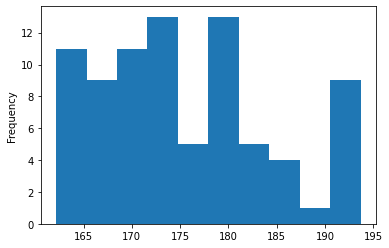

In [ ]:
result_df = pd.DataFrame(results)
result_df[1].plot.hist(bins=10)
result_df[1].describe()

In [ ]:
results.sort(key=lambda x:x[1], reverse=True)
for result in results[:5]:
    idx = result[0]
    params = product_params[idx]

    month_period = params[0]
    num_stock_hold = params[1]
    sell_threshold = params[2]
    sell_ratio = params[3]
    cut_loss_threshold = params[4]

    print(f"{idx}   total balance : {round(result[1], 100)}")
    print(f"        month_period: {month_period}")
    print(f"        num_stock_hold: {num_stock_hold}")
    print(f"        sell_threshold: {sell_threshold}")
    print(f"        sell_ratio: {sell_ratio}")
    print(f"        cut_loss_threshold: {cut_loss_threshold}")
    print()

4   total balance : 193.68841873834856
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.3, 0.4]
        cut_loss_threshold: 0.8

7   total balance : 193.5159000890709
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.1, 0.2, 0.3]
        cut_loss_threshold: 0.8

5   total balance : 193.47152003610938
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.3, 0.4]
        cut_loss_threshold: 0.7

1   total balance : 193.27747127599434
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.2, 0.2]
        cut_loss_threshold: 0.8

2   total balance : 193.06103276632552
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.2, 0.2]
        cut_loss_threshold: 0.7

